## Imports

This notebook leverages [`colpali-engine`](https://github.com/illuin-tech/colpali), the official implementation of ColPali and ColQwen2. This package also contains the training code (processor, collator, trainer...) for fine-tuning these models on your own dataset.

In [24]:
# ! pip install -q -U "colpali-engine>=0.3.1,<0.4.0" requests

In [1]:
from io import BytesIO    # 它提供了在内存中读写字节数据的功能。通常用于处理文件流数据而不必将其存储在磁盘上。这里可能会用于处理图像或其他二进制数据
from typing import Any, List, cast   # Any: 表示任意类型，用于不关心具体类型的变量。
                                     # List: 用于表示列表类型，可以明确指定列表中的元素类型。
                                     # cast: 用于类型强制转换，通常用于将某个对象强制转换为特定类型，虽然实际类型可能不同，但可以确保类型一致性

import requests             # 它用于发送 HTTP 请求。通常用于从网络上获取数据
import torch
from colpali_engine.models import ColQwen2, ColQwen2Processor
from colpali_engine.utils.torch_utils import get_torch_device
from IPython.display import display
from peft import LoraConfig             # LoRA 是一种用于高效微调的大型语言模型的方法
from PIL import Image
from transformers.models.qwen2_vl import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

## A few custom utils

In [2]:
def load_image_from_url(url: str) -> Image.Image:
    """
    Load a PIL image from a valid URL.
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))


def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    scaled_image = image.resize((new_width, new_height))

    return scaled_image

## The `ColQwen2ForRAG` class

In [3]:
class ColQwen2ForRAG(ColQwen2):
    """
    ColQwen2 model implementation that can be used both for retrieval and generation.
    Allows switching between retrieval and generation modes.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._is_retrieval_enabled = True

    def forward(self, *args, **kwargs) -> Any:
        """
        Forward pass that calls either Qwen2VLForConditionalGeneration.forward for generation
        or ColQwen2.forward for retrieval based on the current mode.
        """
        if self.is_retrieval_enabled:
            return ColQwen2.forward(self, *args, **kwargs)
        else:
            return Qwen2VLForConditionalGeneration.forward(self, *args, **kwargs)

    def generate(self, *args, **kwargs):
        """
        Generate text using Qwen2VLForConditionalGeneration.generate.
        """
        if not self.is_generation_enabled:
            raise ValueError(
                "Set the model to generation mode by calling `enable_generation()` before calling `generate()`."
            )
        return super().generate(*args, **kwargs)

    @property
    def is_retrieval_enabled(self) -> bool:
        return self._is_retrieval_enabled

    @property
    def is_generation_enabled(self) -> bool:
        return not self.is_retrieval_enabled

    def enable_retrieval(self) -> None:
        """
        Switch to retrieval mode.
        """
        self.enable_adapters()
        self._is_retrieval_enabled = True

    def enable_generation(self) -> None:
        """
        Switch to generation mode.
        """
        self.disable_adapters()
        self._is_retrieval_enabled = False

## Load ColQwen2

Click on the following link to open the model card for [`vidore/colqwen2-v1.0`](https://huggingface.co/vidore/colqwen2-v1.0).

In [4]:
model_name = "/huggingface/models/vidore/colqwen2-v1.0"

device = get_torch_device("auto")

print(f"Using device: {device}")

# Get the LoRA config from the pretrained retrieval model
lora_config = LoraConfig.from_pretrained(model_name)
# Load the processors
processor_retrieval = cast(ColQwen2Processor, ColQwen2Processor.from_pretrained(model_name))
processor_generation = cast(Qwen2VLProcessor, Qwen2VLProcessor.from_pretrained(lora_config.base_model_name_or_path))

# Load the model with the loaded pre-trained adapter for retrieval
model = cast(
    ColQwen2ForRAG,
    ColQwen2ForRAG.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
)





Using device: cuda:0


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Run the following cell to load the default query and image inputs. If you want to use your own image/query, upload your image in the Google Colab environment, then replace the following variable values with your own.

The images represent your RAG corpus. For simplicity, we will use only 2 images in this example and ask the model to retrieve the most relevant one for the input query.

In [5]:
# Input
'''
query = "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?"

images: List[Image.Image] = [
    load_image_from_url(
        "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/energy_electricity_generation.jpg?raw=true"
    ),
    load_image_from_url(
        "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/shift_kazakhstan.jpg?raw=true"
    ),
]

# NOTE: Because ColQWen2 uses dynamic resolution, we will scale down the images to prevent VRAM overload and faster
# inference times for both indexing and generation. From my experiments, a scale of 512 pixels is a good default for
# document tasks. Feel free to experiment with higher resolutions, especially if the text on your document is small.
images = [scale_image(image, new_height=512) for image in images]

for image in images:
    display(scale_image(image, new_height=256))
'''

'\nquery = "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?"\n\nimages: List[Image.Image] = [\n    load_image_from_url(\n        "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/energy_electricity_generation.jpg?raw=true"\n    ),\n    load_image_from_url(\n        "https://github.com/tonywu71/colpali-cookbooks/blob/main/examples/data/shift_kazakhstan.jpg?raw=true"\n    ),\n]\n\n# NOTE: Because ColQWen2 uses dynamic resolution, we will scale down the images to prevent VRAM overload and faster\n# inference times for both indexing and generation. From my experiments, a scale of 512 pixels is a good default for\n# document tasks. Feel free to experiment with higher resolutions, especially if the text on your document is small.\nimages = [scale_image(image, new_height=512) for image in images]\n\nfor image in images:\n    display(scale_image(image, new_height=256))\n'

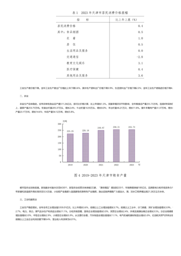

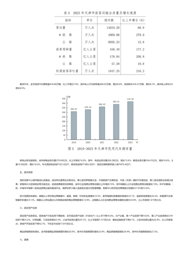

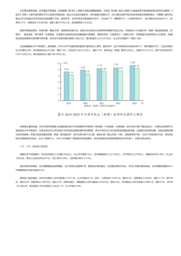

In [5]:
# Inputs
# query = "Quelle partie de la production pétrolière du Kazakhstan provient de champs en mer ?"
# query = "2023年天津市民用汽车拥有量是多少 ?"
query = "天津市在国际国内高水平体育赛事中获得金牌，银牌，铜牌分别是多少?"

# 修改为本地路径

'''
image_paths: List[str] = [
    "/Data/energy_electricity_generation.jpg",  # 替换为你本地的图片路径
    "/Data/shift_kazakhstan.jpg",  # 替换为你本地的图片路径
]
'''
image_paths: List[str] = [
    "/Data/image/jpg/page_3.jpg",  # 替换为你本地的图片路径
    "/Data/image/jpg/page_5.jpg",  # 替换为你本地的图片路径
    "/Data/image/jpg/7.jpg",
]

# 加载本地图片
images: List[Image.Image] = [Image.open(image_path) for image_path in image_paths]

# NOTE: Because ColQWen2 uses dynamic resolution, we will scale down the images to prevent VRAM overload and faster
# inference times for both indexing and generation. From my experiments, a scale of 512 pixels is a good default for
# document tasks. Feel free to experiment with higher resolutions, especially if the text on your document is small.
images = [scale_image(image, new_height=512) for image in images]

for image in images:
    display(scale_image(image, new_height=256))


## Part 1 of RAG: Retrieval

This is the retrieval part of the RAG. In this example, we only keep the top-1 result for demonstration purposes.

In practice, using more results (e.g., top-5) can improve the quality of the final answer.

Image retrieved for the following query: `天津市在国际国内高水平体育赛事中获得金牌，银牌，铜牌分别是多少?`


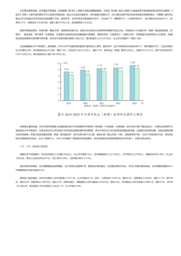

In [6]:
# Process the inputs
batch_images = processor_retrieval.process_images(images).to(model.device)
batch_queries = processor_retrieval.process_queries([query]).to(model.device)

# Forward pass
model.enable_retrieval()

with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

# Calculate the similarity scores
scores = processor_retrieval.score_multi_vector(query_embeddings, image_embeddings)

# Get the top-1 page image
retrieved_image_index = scores.argmax().item()
retrieved_image = images[retrieved_image_index]

print(f"Image retrieved for the following query: `{query}`")
display(scale_image(retrieved_image, new_height=256))

## Part 2 of RAG: Augmented Generation

Now comes the generation part of the RAG. Using the retrieved image from the retrieval part, we will disable the retrieval adapter in ColQwen2 to use its Qwen2-VL VLM backbone to generate the answer based on both the query and the retrieved image.

In [7]:
# Preprocess the inputs
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": f"Answer the following question using the input image: {query}",
            },
        ],
    }
]
text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
inputs_generation = processor_generation(
    text=[text_prompt],
    images=[image],
    padding=True,
    return_tensors="pt",
).to(device)

# Generate the RAG response
model.enable_generation()
output_ids = model.generate(**inputs_generation, max_new_tokens=128)

# Ensure that only the newly generated token IDs are retained from output_ids
generated_ids = [output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]

# Decode the RAG response
output_text = processor_generation.batch_decode(
    generated_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True,
)

print(output_text)

['根据图片中的信息，天津在国际国内高水平体育赛事中获得的金牌、银牌、铜牌分别是：\n\n- 金牌：1枚\n- 银牌：2枚\n- 铜牌：3枚']


# 将图片分辨率进行调整后的代码

In [1]:
from io import BytesIO
from typing import Any, List, cast

import requests
import torch
from colpali_engine.models import ColQwen2, ColQwen2Processor
from colpali_engine.utils.torch_utils import get_torch_device
from IPython.display import display
from peft import LoraConfig
from PIL import Image
from transformers.models.qwen2_vl import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

def load_image_from_path(image_path: str) -> Image.Image:
    """
    Load a PIL image from a local file path.
    """
    return Image.open(image_path)


# 调整后的图像缩放函数，支持更高的分辨率
def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    使用更高的分辨率来缩放图像，避免清晰度丧失。
    """
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # 使用更高的分辨率（可根据需要调整）
    scaled_image = image.resize((new_width, new_height), Image.LANCZOS)  # 使用LANCZOS算法保持清晰度

    return scaled_image

class ColQwen2ForRAG(ColQwen2):
    """
    ColQwen2 model implementation that can be used both for retrieval and generation.
    Allows switching between retrieval and generation modes.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._is_retrieval_enabled = True

    def forward(self, *args, **kwargs) -> Any:
        """
        Forward pass that calls either Qwen2VLForConditionalGeneration.forward for generation
        or ColQwen2.forward for retrieval based on the current mode.
        """
        if self.is_retrieval_enabled:
            return ColQwen2.forward(self, *args, **kwargs)
        else:
            return Qwen2VLForConditionalGeneration.forward(self, *args, **kwargs)

    def generate(self, *args, **kwargs):
        """
        Generate text using Qwen2VLForConditionalGeneration.generate.
        """
        if not self.is_generation_enabled:
            raise ValueError(
                "Set the model to generation mode by calling `enable_generation()` before calling `generate()`."
            )
        return super().generate(*args, **kwargs)

    @property
    def is_retrieval_enabled(self) -> bool:
        return self._is_retrieval_enabled

    @property
    def is_generation_enabled(self) -> bool:
        return not self.is_retrieval_enabled

    def enable_retrieval(self) -> None:
        """
        Switch to retrieval mode.
        """
        self.enable_adapters()
        self._is_retrieval_enabled = True

    def enable_generation(self) -> None:
        """
        Switch to generation mode.
        """
        self.disable_adapters()
        self._is_retrieval_enabled = False


model_name = "/huggingface/models/vidore/colqwen2-v1.0"
device = get_torch_device("auto")

print(f"Using device: {device}")

# Get the LoRA config from the pretrained retrieval model
lora_config = LoraConfig.from_pretrained(model_name)

# Load the processors
processor_retrieval = cast(ColQwen2Processor, ColQwen2Processor.from_pretrained(model_name))
processor_generation = cast(Qwen2VLProcessor, Qwen2VLProcessor.from_pretrained(lora_config.base_model_name_or_path))

# Load the model with the loaded pre-trained adapter for retrieval
model = cast(
    ColQwen2ForRAG,
    ColQwen2ForRAG.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
)


Using device: cuda:0


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:


image_paths = [
    "/Data/image/jpg/page_3.jpg",  # 替换为实际路径
    "/Data/image/jpg/page_5.jpg",  # 替换为实际路径
    "/Data/image/jpg/7.jpg",
]

# Inputs
# query = "2023年天津市民用汽车拥有量是多少 ? 2023年机场旅客吞吐量的绝对数是多少? 比上年增加了多少?"
query = '天津市在国际国内高水平体育赛事中获得金牌，银牌，铜牌分别是多少?'
# query = "天津市全年农林牧渔业总产值是多少 ?"
# query = "天津市全面全市工业增加值是多少 ?比上年增长了多少?"
images: List[Image.Image] = [load_image_from_path(image_path) for image_path in image_paths]
images = [scale_image(image, new_height=1024) for image in images]
'''
for image in images:
    display(scale_image(image, new_height=512))
'''


'\nfor image in images:\n    display(scale_image(image, new_height=512))\n'

In [ ]:
batch_images = processor_retrieval.process_images(images).to(model.device)
batch_queries = processor_retrieval.process_queries([query]).to(model.device)

# 启动检索模式
model.enable_retrieval()

with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

# 计算相似度
scores = processor_retrieval.score_multi_vector(query_embeddings, image_embeddings)

# 获取最相关的图像
retrieved_image_index = scores.argmax().item()
retrieved_image = images[retrieved_image_index]

print(f"Image retrieved for the following query: `{query}`")
display(scale_image(retrieved_image, new_height=512))  # 显示高分辨率的检索图像

# 生成过程，仍然使用更高分辨率的图像
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": f"Answer the following question using the input image: {query}",
            },
        ],
    }
]
text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
inputs_generation = processor_generation(
    text=[text_prompt],
    images=[retrieved_image],  # 使用检索到的图像进行生成
    padding=True,
    return_tensors="pt",
).to(device)

# 生成 RAG 响应
model.enable_generation()
output_ids = model.generate(**inputs_generation, max_new_tokens=128)

# 处理生成的文本
generated_ids = [output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]
output_text = processor_generation.batch_decode(
    generated_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True,
)

print(output_text)

# PDF的检索方法代码

In [9]:
from io import BytesIO
from typing import Any, List, cast
import os
import torch
from colpali_engine.models import ColQwen2, ColQwen2Processor
from colpali_engine.utils.torch_utils import get_torch_device
from peft import LoraConfig
from PIL import Image
from transformers.models.qwen2_vl import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from pdf2image import convert_from_path  # 引入PDF转图片的功能

def load_image_from_path(image_path: str) -> Image.Image:
    """
    Load a PIL image from a local file path.
    """
    return Image.open(image_path)

# 调整后的图像缩放函数，支持更高的分辨率
def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    使用更高的分辨率来缩放图像，避免清晰度丧失。
    """
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # 使用更高的分辨率（可根据需要调整）  
    scaled_image = image.resize((new_width, new_height), Image.LANCZOS)  # 使用LANCZOS算法保持清晰度

    return scaled_image

class ColQwen2ForRAG(ColQwen2):
    """
    ColQwen2 model implementation that can be used both for retrieval and generation.
    Allows switching between retrieval and generation modes.
    """

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._is_retrieval_enabled = True

    def forward(self, *args, **kwargs) -> Any:
        """
        Forward pass that calls either Qwen2VLForConditionalGeneration.forward for generation
        or ColQwen2.forward for retrieval based on the current mode.
        """
        if self.is_retrieval_enabled:
            return ColQwen2.forward(self, *args, **kwargs)
        else:
            return Qwen2VLForConditionalGeneration.forward(self, *args, **kwargs)

    def generate(self, *args, **kwargs):
        """
        Generate text using Qwen2VLForConditionalGeneration.generate.
        """
        if not self.is_generation_enabled:
            raise ValueError(
                "Set the model to generation mode by calling `enable_generation()` before calling `generate()`."
            )
        return super().generate(*args, **kwargs)

    @property
    def is_retrieval_enabled(self) -> bool:
        return self._is_retrieval_enabled

    @property
    def is_generation_enabled(self) -> bool:
        return not self.is_retrieval_enabled

    def enable_retrieval(self) -> None:
        """
        Switch to retrieval mode.
        """
        self.enable_adapters()
        self._is_retrieval_enabled = True

    def enable_generation(self) -> None:
        """
        Switch to generation mode.
        """
        self.disable_adapters()
        self._is_retrieval_enabled = False


model_name = "/huggingface/models/vidore/colqwen2-v1.0"
# device = get_torch_device("auto")


# Get the LoRA config from the pretrained retrieval model
lora_config = LoraConfig.from_pretrained(model_name)

# Load the processors
processor_retrieval = cast(ColQwen2Processor, ColQwen2Processor.from_pretrained(model_name))
processor_generation = cast(Qwen2VLProcessor, Qwen2VLProcessor.from_pretrained(lora_config.base_model_name_or_path))





device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Load the model with the loaded pre-trained adapter for retrieval
model = cast(
    ColQwen2ForRAG,
    ColQwen2ForRAG.from_pretrained(
        model_name,
        torch_dtype=torch.bfloat16,
        device_map=device,
    ),
)

Using device: cuda:5


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
# PDF 文件路径
pdf_path = "/Data/PDF/2023tj.pdf"  # 替换为实际的PDF路径

# 将PDF转换为图像
images: List[Image.Image] = convert_from_path(pdf_path)

# 调整图片尺寸
images = [scale_image(image, new_height=1024) for image in images]

# 显示图像时进行相应调整
'''
for image in images:
    display(scale_image(image, new_height=512))  # 生成时显示较高分辨率的图像
'''
# 定义查询内容
# query = "天津市在国际国内高水平体育赛事中获得金牌，银牌，铜牌分别是多少?"
# query = "天津市2023年居民人均可支配收入是多少? 比上年增长了多少?"
query = "你能将2019年-2023年天津市居民人均可支配收入这部分进行总结吗，描述的是什么?"

# query = "天津市2023年全年一般公共预算收入是多少? 战略性新兴产业增加值占工业的比重是多少?"





Image retrieved for the following query: `你能将2019年-2023年天津市居民人均可支配收入这部分进行总结吗，描述的是什么?`


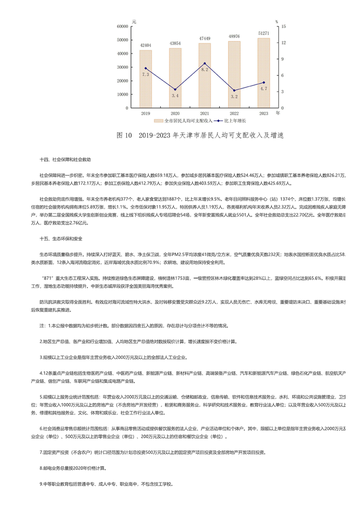

['2019年-2023年天津市居民人均可支配收入的总结如下：\n\n1. **总体趋势**：2019年到2023年，天津市居民人均可支配收入逐年增长，呈现出稳步上升的趋势。\n\n2. **年增长率**：2019年到2023年，年增长率分别为7.3%、8.2%、8.6%、9.2%、9.7%。\n\n3. **收入水平**：2023年，天津市居民人均可支配收入达到51271元，']


In [11]:
# 处理输入
batch_images = processor_retrieval.process_images(images).to(model.device)
batch_queries = processor_retrieval.process_queries([query]).to(model.device)

# 启动检索模式
model.enable_retrieval()

with torch.no_grad():
    image_embeddings = model.forward(**batch_images)
    query_embeddings = model.forward(**batch_queries)

# 计算相似度
scores = processor_retrieval.score_multi_vector(query_embeddings, image_embeddings)

# 获取最相关的图像
retrieved_image_index = scores.argmax().item()
retrieved_image = images[retrieved_image_index]

print(f"Image retrieved for the following query: `{query}`")
display(scale_image(retrieved_image, new_height=512))  # 显示高分辨率的检索图像

# 生成过程，仍然使用更高分辨率的图像
conversation = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": retrieved_image,  # 使用检索到的图像进行生成
            },
            {
                "type": "text",
                "text": f"Answer the following question using the input image: {query}",
            },
        ],
    }
]
text_prompt = processor_generation.apply_chat_template(conversation, add_generation_prompt=True)
inputs_generation = processor_generation(
    text=[text_prompt],
    images=[retrieved_image],  # 使用检索到的图像进行生成
    padding=True,
    return_tensors="pt",
).to(device)

# 生成 RAG 响应
model.enable_generation()
output_ids = model.generate(**inputs_generation, max_new_tokens=128)

# 处理生成的文本
generated_ids = [output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs_generation.input_ids, output_ids)]
output_text = processor_generation.batch_decode(
    generated_ids,
    skip_special_tokens=True,
    clean_up_tokenization_spaces=True,
)

print(output_text)